[*********************100%***********************]  1 of 1 completed

Observaciones: precios=1258 | retornos=1257


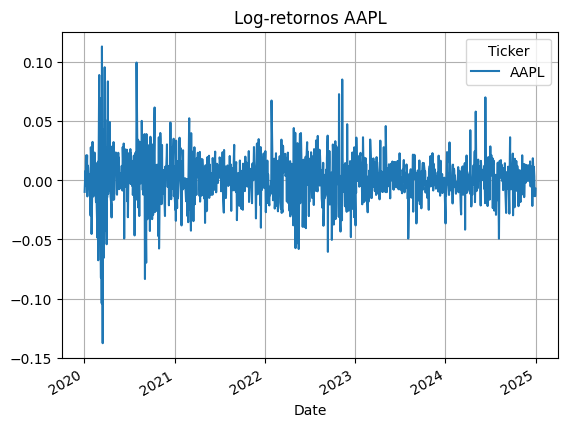

In [3]:
# GARCH: pipeline completo

import numpy as np                              # para operaciones numéricas (log, shift, etc.)
import pandas as pd                             # estructuras de datos (Series/DataFrame)
import yfinance as yf                           # descarga de precios desde Yahoo! Finance
import matplotlib.pyplot as plt                 # gráficos

# utilidades de statsmodels (ACF, PACF, ADF, Ljung-Box, ARCH LM)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

from arch import arch_model                     # modelos ARCH/GARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error  # métricas

# 0) Parámetros ------------
TICKER = "AAPL"                                 # ticker del activo (editable)
START  = "2020-01-01"                           # fecha inicial
END    = "2025-01-01"                           # fecha final
TEST_SIZE = 250                                 # tamaño del set de prueba (~1 año hábil)

# 1) Datos y log-retornos ---
px = yf.download(                               # descarga precios ajustados
    TICKER, start=START, end=END, auto_adjust=True
)["Close"].dropna()
r  = np.log(px / px.shift(1)).dropna()          # log-retorno: ln(P_t / P_{t-1})
print(f"Observaciones: precios={len(px)} | retornos={len(r)}")

fig, ax = plt.subplots()                        # figura y ejes
r.plot(ax=ax, title=f"Log-retornos {TICKER}")   # gráfica rápida de la serie de retornos
plt.grid()                                      # rejilla
plt.show()                                      # mostrar figura



ADF log-retornos: stat=-11.284, p-value=0.0000


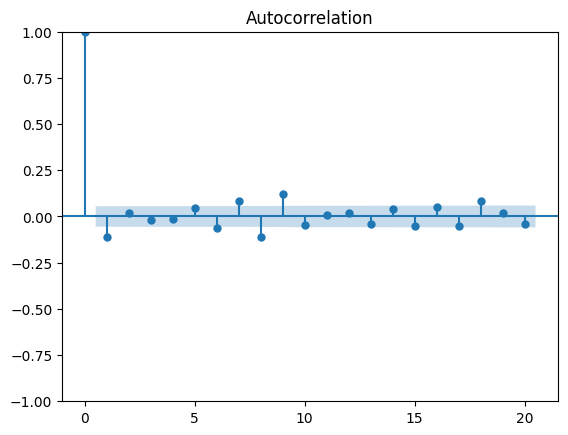

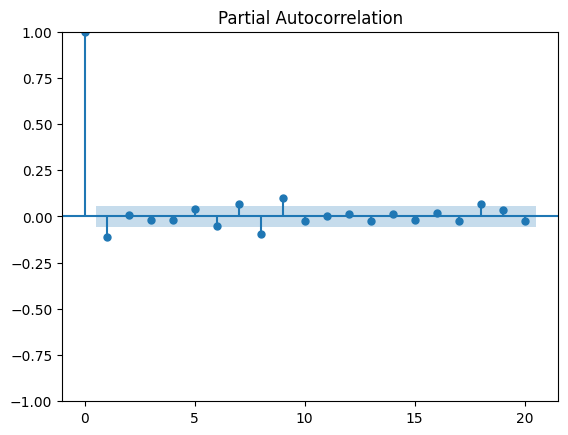

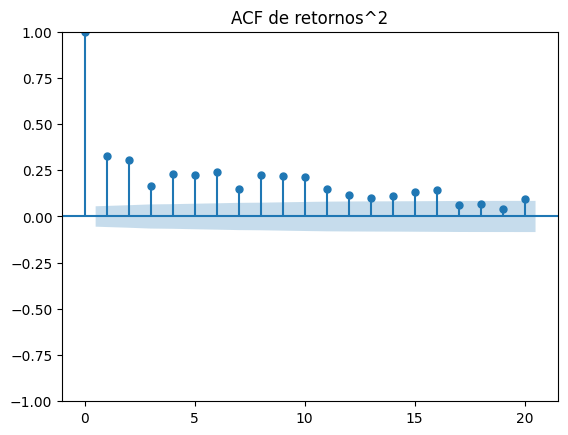

In [5]:
# ======== 2) ADF (opcional), ACF y PACF =========
adf_stat, adf_p,*_ = adfuller(r)           # prueba ADF sobre los retornos
print(f"ADF log-retornos: stat={adf_stat:.3f}, p-value={adf_p:.4f}")

plot_acf(r, lags=20)                       # ACF de retornos
plt.show()
plot_pacf(r, lags=20)                      # PACF de retornos
plt.show()

# ACF de retornos al cuadrado (clústeres de volatilidad)
plot_acf(r**2, lags=20, title="ACF de retornos^2")
plt.show()

# ========= 3) Split train/test =========
train = r.iloc[:-TEST_SIZE].copy()         # conjunto de entrenamiento
test  = r.iloc[-TEST_SIZE:].copy()         # conjunto de prueba (~ TEST_SIZE obs.)

In [6]:
# ========= 4) Estimar GARCH(1,1) con t-Student en TRAIN =========
# mean='Constant' -> media constante en el modelo de retornos
# vol='Garch', p=1, q=1 -> varianza condicional GARCH(1,1)
# dist='t' -> distribución t de Student (colas pesadas)
am  = arch_model(train, mean='Constant', vol='Garch', p=1, q=1, dist='t')

# ajuste del modelo; update_freq=0 suprime el progreso; disp='off' silencia la salida
res = am.fit(update_freq=0, disp='off')

# resumen del ajuste (parámetros, errores estándar, diagnóstico básico)
print(res.summary())

# ========= 5) Diagnóstico en TRAIN =========
# residuales estandarizados del modelo (para pruebas de autocorrelación)
std_resid = res.std_resid.dropna()

# Ljung-Box sobre residuales y sobre residuales al cuadrado (deberían no tener autocorrelación)
lb_r   = acorr_ljungbox(std_resid,      lags=[10, 20], return_df=True)
lb_var = acorr_ljungbox(std_resid**2,   lags=[10, 20], return_df=True)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1962.09
Distribution:      Standardized Student's t   AIC:                          -3914.17
Method:                  Maximum Likelihood   BIC:                          -3889.60
                                              No. Observations:                 1007
Date:                      Tue, Sep 23 2025   Df Residuals:                     1006
Time:                              10:20:18   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/home/fabian/miniconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004469. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
# ========= 4) Estimar GARCH(1,1) con t-Student en TRAIN =========
# mean='Constant' -> media constante (alternativa: 'ARX' para incluir parte AR en la media)
# dist='t' -> distribución t de Student (colas pesadas)
am  = arch_model(train, mean='Constant', vol='Garch', p=1, q=1, dist='t')

# Ajuste silencioso
res = am.fit(update_freq=0, disp='off')

# Resumen y criterios de información
print(res.summary())
print(f"AIC={res.aic:.2f}  BIC={res.bic:.2f}  LLF={res.loglikelihood:.2f}")

# ========= 5) Diagnóstico en TRAIN =========
std_resid = res.std_resid.dropna()                               # residuales estandarizados
lb_mean = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)     # Ljung-Box sobre residuales
lb_var  = acorr_ljungbox(std_resid**2, lags=[10, 20], return_df=True)  # Ljung-Box sobre residuales^2
print("Ljung-Box en resid estandarizados (media):")
print(lb_mean)
print("\nLjung-Box en resid estandarizados^2 (varianza):")
print(lb_var)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1962.09
Distribution:      Standardized Student's t   AIC:                          -3914.17
Method:                  Maximum Likelihood   BIC:                          -3889.60
                                              No. Observations:                 1007
Date:                      Tue, Sep 23 2025   Df Residuals:                     1006
Time:                              10:23:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/home/fabian/miniconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004469. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
